In [1]:
import os
import cv2
import math
import time
import mediapipe as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [2]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

train_dir = ".\\transformed_data"
train_path, test_path = ".\\train_noz.csv", ".\\test_noz.csv"

def dataset2images(root_dir, output_path):
    datasets = []
    for img_name in tqdm(os.listdir(root_dir)):
        img_path = os.path.join(root_dir, img_name)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        landmarks = []
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append(lm.x)
                    landmarks.append(lm.y)
                    landmarks.append(lm.z)
                datasets.append(landmarks + [img_name[0]])
            
    pd.DataFrame(datasets).to_csv(output_path, header=False, index=False)

In [8]:
dataset2images(train_dir, train_path)
dataset2images(train_dir, test_path) # 实在数据量太少，就直接用同样的数据做测试集了

100%|██████████| 386/386 [00:19<00:00, 19.84it/s]


In [3]:
class KeypointsDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.samples = pd.read_csv(data_path).to_numpy()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        keypoints = sample[:-1].astype(np.float32)
        label = sample[-1].astype(np.int64)

        keypoints = self.transform(keypoints) if self.transform else torch.tensor(keypoints, dtype=torch.float32)
        return keypoints, label


FINGER_JOINTS_INDICES = [
    (2, 3, 4),   # 拇指：(MCP, IP, Tip)
    (5, 6, 7),   # 食指：(MCP, PIP, DIP)
    (9, 10, 11), # 中指
    (13, 14, 15),# 无名指
    (17, 18, 19) # 小指
]

# 辅助函数：计算三点 P1-P2-P3 在 P2 处的夹角（度数）
def calculate_angle(p1, p2, p3):
    """
    p1, p2, p3 是 (x, y) 坐标点或 (x, y, z) 坐标点。
    """
    p1 = np.array(p1)
    p2 = np.array(p2)
    p3 = np.array(p3)
    v1 = p1 - p2
    v2 = p3 - p2
    dot_product = np.dot(v1, v2)
    magnitude_v1 = np.linalg.norm(v1)
    magnitude_v2 = np.linalg.norm(v2)
    
    if magnitude_v1 == 0 or magnitude_v2 == 0:
        return 0.0
        
    cosine_angle = dot_product / (magnitude_v1 * magnitude_v2)
    cosine_angle = np.clip(cosine_angle, -1.0, 1.0)
    
    angle = np.arccos(cosine_angle)
    return np.degrees(angle)


EPSILON = 1e-6 

def keypoints_transform(keypoints):
    # 1. 转换为 (21, 3) 矩阵 (X, Y, Z)
    kp_matrix_raw = torch.tensor(keypoints, dtype=torch.float32).reshape(21, 3)
    
    # 转换为 numpy 数组进行线性代数运算
    kp_matrix_np = kp_matrix_raw.numpy()
    
    # 2. 坐标中心化 (以手腕 P0 为原点)
    wrist = kp_matrix_np[0]
    kp_centered = kp_matrix_np - wrist
    
    # --- 3. 姿态归一化：计算 3D 旋转矩阵 (更鲁棒的版本) ---
    
    # V_Y (主轴): 手掌长度轴 (P0 -> P9)
    V_Y_raw = kp_centered[9]
    
    # V_Z (法线轴): 手掌法向量 V_Z = (P5 - P0) x (P17 - P0)
    V_Z_raw = np.cross(kp_centered[5], kp_centered[17])
    
    # --- 安全检查与归一化 ---
    R = np.eye(3) # 默认不旋转
    
    # 检查主轴和法线轴的有效性
    norm_Y = np.linalg.norm(V_Y_raw)
    norm_Z = np.linalg.norm(V_Z_raw)
    
    # 只有当两个主要参考轴都有效时才进行旋转
    if norm_Y > EPSILON and norm_Z > EPSILON:
        
        V_Y_norm = V_Y_raw / norm_Y
        V_Z_norm = V_Z_raw / norm_Z
        
        # V_X (第三轴): 通过交叉乘积确保正交性 V_X = V_Y x V_Z
        V_X_raw = np.cross(V_Y_norm, V_Z_norm)
        norm_X = np.linalg.norm(V_X_raw)

        if norm_X > EPSILON:
            V_X_norm = V_X_raw / norm_X
            
            # 由于 V_Y_norm 和 V_Z_norm 已经归一化，但 V_Z_norm 可能与 V_Y_norm 不完全正交
            # 我们重新计算 V_Z_norm，确保它是正交基，这一步是为了 Gram-Schmidt 矫正
            # V_Z_final = V_X_norm x V_Y_norm 
            V_Z_final = np.cross(V_X_norm, V_Y_norm)
            
            # 旋转矩阵 R 的行是新坐标系的基向量 (新X, 新Y, 新Z)
            R = np.vstack([V_X_norm, V_Y_norm, V_Z_final])
            
            # 应用旋转：P_rotated = P_centered @ R.T (注意：我们构造的R是基向量的行，所以需要转置)
            # 或者直接用 P_rotated = R @ P_centered.T
            kp_rotated = (R @ kp_centered.T).T 
        else:
            # 如果 V_Y 和 V_Z 平行 (极少发生)，保持不旋转
            kp_rotated = kp_centered
    else:
        # 如果无法计算主轴或法线，保持不旋转
        kp_rotated = kp_centered


    # --- 6. 缩放归一化 (63 维) ---
    # 使用原始 V_Y 长度作为缩放比例
    scale = norm_Y # 使用之前计算的 norm_Y
    
    if scale > EPSILON:
        kp_normalized = kp_rotated / scale
    else:
        kp_normalized = kp_rotated
        
    # 展平归一化 3D 坐标特征 (21 * 3 = 63 维)
    feature_coords = torch.tensor(kp_normalized.flatten(), dtype=torch.float32)

    
    # --- 7. 角度特征处理 (5 维) ---
    # 角度计算保持不变
    angle_features = []
    
    for p1_idx, p2_idx, p3_idx in FINGER_JOINTS_INDICES:
        # 使用旋转后的坐标计算角度，确保特征一致性
        p1 = kp_rotated[p1_idx] 
        p2 = kp_rotated[p2_idx]
        p3 = kp_rotated[p3_idx]
        
        angle = calculate_angle(p1, p2, p3) 
        
        # 将角度归一化到 [0, 1] 范围 
        normalized_angle = angle / 180.0 
        angle_features.append(normalized_angle)

    feature_angles = torch.tensor(angle_features, dtype=torch.float32)

    # --- 8. 合并特征 (63 + 5 = 68 维) ---
    final_features = torch.cat((feature_coords, feature_angles))
    
    return final_features

train_dataset = KeypointsDataset(train_path, transform=keypoints_transform)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)
test_dataset = KeypointsDataset(test_path, transform=keypoints_transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

In [4]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(68, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # self.bn = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [5]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [6]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for keypoints, labels in dataloader:
        keypoints, labels = keypoints.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * keypoints.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for keypoints, labels in dataloader:
            keypoints, labels = keypoints.to(device), labels.to(device)

            outputs = model(keypoints)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * keypoints.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

Epoch 1/300, Train Loss: 2.3196, Train Acc: 0.0882, Test Loss: 2.2800, Test Acc: 0.2516
Epoch 100/300, Train Loss: 0.8367, Train Acc: 0.6895, Test Loss: 0.6527, Test Acc: 0.8595
Epoch 200/300, Train Loss: 0.4750, Train Acc: 0.8725, Test Loss: 0.3376, Test Acc: 0.9085
Epoch 300/300, Train Loss: 0.3460, Train Acc: 0.8791, Test Loss: 0.2058, Test Acc: 0.9477


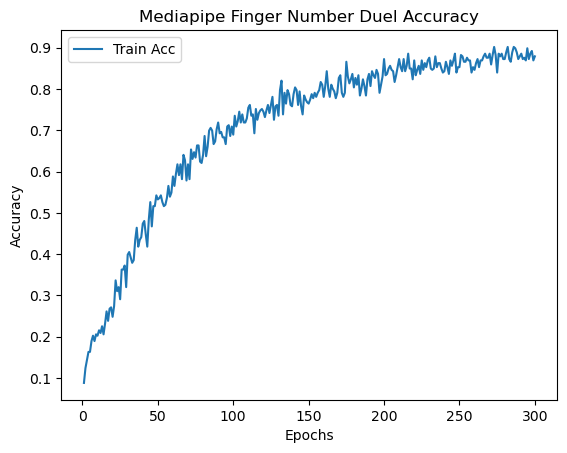

In [7]:
EPOCHS = 300
train_acces = []
test_acces = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    train_acces.append(train_acc)
    test_acces.append(test_acc)

plt.plot(range(1, EPOCHS+1), train_acces, label='Train Acc')
# plt.plot(range(1, EPOCHS+1), test_acces, label='Test Acc')
plt.title('Mediapipe Finger Number Duel Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
# torch.save(model.state_dict(), "mlp_model_weights.pth")

model = MLP().to(device)
model.load_state_dict(torch.load("mlp_model_weights.pth"))
model.eval()

MLP(
  (fc1): Linear(in_features=68, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [ ]:
cap = cv2.VideoCapture(3)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    # frame = cv2.flip(frame, 1)
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    machine_left = 0
    machine_right = 0

    if results.multi_hand_landmarks:
        for hand_landmarks, hand_info in zip(results.multi_hand_landmarks, results.multi_handedness):
            # 获取手的左右
            hand_label = hand_info.classification[0].label  # 'Left' 或 'Right'

            # 提取关键点
            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
                # keypoints.extend([lm.x, lm.y])
            keypoints = keypoints_transform(keypoints).unsqueeze(0).to(device)

            # 预测手势数字
            res = model(keypoints)
            predicted_class = torch.argmax(res, dim=1).item()

            # ③累加到对应手
            if hand_label == "Left":
                machine_left += predicted_class
            else:
                machine_right += predicted_class

            # ④绘制框和预测结果
            h, w, c = frame.shape
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            x_list = [int(lm.x * w) for lm in hand_landmarks.landmark]
            y_list = [int(lm.y * h) for lm in hand_landmarks.landmark]
            x_min, x_max = min(x_list), max(x_list)
            y_min, y_max = min(y_list), max(y_list)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
            cv2.putText(frame, str(predicted_class), (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
    
    cv2.imshow("Hand Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [10]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

cap = cv2.VideoCapture(3)

Z_THRESHOLD = -0.05  # 碰动作阈值
COOLDOWN = 0.5       # 碰冷却时间（秒）

# 双边分数
left_score = 0
right_score = 0

# 上一次碰时间（按手框位置）
last_touch_time = {"Left": 0, "Right": 0}

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)
    h, w, c = frame.shape
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks in results.multi_hand_landmarks:
            # -------------------
            # 手势预测
            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            keypoints_tensor = keypoints_transform(keypoints).unsqueeze(0).to(device)
            res = model(keypoints_tensor)
            predicted_class = torch.argmax(res, dim=1).item()

            # -------------------
            # 手框坐标
            x_list = [int(lm.x * w) for lm in hand_landmarks.landmark]
            y_list = [int(lm.y * h) for lm in hand_landmarks.landmark]
            x_min, x_max = min(x_list), max(x_list)
            y_min, y_max = min(y_list), max(y_list)

            # 手中心位置
            cx = (x_min + x_max) // 2

            # -------------------
            # 碰检测
            z_value = hand_landmarks.landmark[9].z
            is_touching = z_value < Z_THRESHOLD

            current_time = time.time()
            # 判断手在左区还是右区
            side = "Left" if cx < w // 2 else "Right"

            # -------------------
            # 更新分数（加冷却机制）
            if is_touching and current_time - last_touch_time[side] > COOLDOWN:
                if side == "Left":
                    left_score += predicted_class
                else:
                    right_score += predicted_class
                last_touch_time[side] = current_time

            # -------------------
            # 绘制手框和关键点
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # 显示手势、z 值和状态
            status_text = f'Num:{predicted_class} z:{z_value:.3f} {"Touch!" if is_touching else "Idle"}'
            cv2.putText(frame, status_text, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255) if is_touching else (255,0,0), 2)

    # -------------------
    # 显示左右边分数
    cv2.putText(frame, f'Left side score: {left_score}', (10, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2)
    cv2.putText(frame, f'Right side score: {right_score}', (1010, 30),
                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,255), 2)

    cv2.imshow("Hand Gesture and Touch Detection", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
